# 파이썬을 이용한 예지보수 실습

- 파이썬 기초
 - 파일 다루기, 데이터프레임
- 탐색적 분석
 - 설명적 분석, 기초 통계분석, 시각화
- 데이터 전처리
 - 결측치 처리, 스케일링
- 예측분석
 - 예지보수, 선형모델, 회귀예측, 분류예측
- 머신러닝
 - 머신러닝, 트리모델, 신경망 모델
- 이상치 탐지
 - 차원축소, PCA, t-SNE

# 예지보수 

- Predictive Maintenance (PM)
 - 대상: 장비, 부품, 제품
- 보수의 종류
  > 고장 후 보수: 기기가 고장나면 보수를 하는 것   
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것    
  > 예지 보수: 고장을 예측하여 적절한 시점에 보수를 하는 것    
- 예제
  - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측

## 머신러닝을 이용한 예측 성능 향상

- 항공기 엔진 운영 데이터 (센서 및 설정 데이터)를 보고 고장시점을 예측하는 문제
- 머신러닝의 회귀 및 분류 예측 모델을 사용한다
- 신경망의 LSTM 모델을 사용한다
- 참고 [MS Azure](https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2)


## PM 회귀 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

# 파이썬 기초

- 라이브러리 사용하기: import로 필요한 라이브러리를 불러온다

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import keras
from keras import Sequential
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier, LGBMRegressor
from keras.layers import Dropout, LSTM, Dense, Activation
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

# 데이터

- 항공기 엔진 운영 센서 및 설정 데이터와 고장시점 정보 데이터를 사용한다 (마이크로소프트사의 Azure에서 제공)
- 공개 데이터 주소: [https://azuremlsamples.azureml.net/templatedata/PM_train.txt](https://azuremlsamples.azureml.net/templatedata/PM_train.txt)
- 모델을 만드는데 사용할 훈련 데이터에는 엔진별 가동 데이터와 수명정보가 있고 (고장시점까지 데이터가 주어진다)
- 최종 개발한 모델의 성능을 테스트하는데 사용할 데이터에는 엔진 가동 정보만 있고 정답은 (향후 잔여수명)은 별도의 truth 데이터로 제공한다

## 훈련 데이터 다루기

- 파이썬의 판다스(pandas) 라이브러리가 제공하는 read_csv() 함수로 데이터를 읽는다
- 데이터프레임(DataFrame) 형태로 읽는다
 - 데이터프레임은 2차원, 테이블 구조의 데이터를 다루며 액셀과 같이 편리한 기능을 수행할 수 있다
 - 행과 열로 구성되며, 행은 샘플을 구분하고 열은 특성(features)을 구분한다


In [ ]:
# 제공 데이터 URL 주소
data_address = "https://azuremlsamples.azureml.net/templatedata/PM_train.txt"

In [ ]:
# 파이썬의 판다스 라이브러리가 제공하는 read_csv() 함수로 데이터를 읽는다
# 데이터프레임 형태로 읽는다

import pandas as pd
df = pd.read_csv(data_address, sep=" ", header=None)

In [ ]:
df[:3]

In [ ]:
df.info()

In [ ]:
# 빈 컬럼 삭제
df.drop(df.columns[[26, 27]], axis=1, inplace=True)
df[:3]

In [ ]:
# 주어진 컬럼 이름 지정

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
df.columns = column_names
df[:3]

## 고장 시점 정보 얻기
- 총 100개의 엔진에 대해서 각 엔진별로 고장나기 전까지의 데이터가 주어져 있다 [고장시점 정보 보기](https://az712634.vo.msecnd.net/samplesimg/v1/T4/labeling_1.png)

## 레이블(y)  추가
- 회귀 분석에서는 잔여시간(TTF: Time to Fail)을 예측하며 각 상태(State) 값을 보고 앞으로 남은 잔여시간을 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 특정 기간 이내에 고장 날지 여부를 예측한다. 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
- 회귀 및 분류를 위한 레이블을 각각 만들겠다

- RUL(Remaining Useful Life)
  - 같은 엔진 ID에 대해서 최대 cycle 값이 "수명"을 나타낸다
  - 이 수명값을 rul 데이터프레임에 저장한다
  - 같은 엔진들 즉 같은 'id'를 같는 샘플들을 별도의 데이터프레임으로 만드는 groupby를 사용한다

## 판다스의 그룹바이 사용
- 100개 엔진별 데이터프레임을 내부적으로 만든다

In [ ]:
g = df.groupby('id')
g

In [ ]:
# 서브 그룹의 갯수 (엔진의 수이 100개임)
g.ngroups

In [ ]:
g.get_group(1)

In [ ]:
g.get_group(1)['cycle']

In [ ]:
g.get_group(1)['cycle'].max()

In [ ]:
g.get_group(2)

In [ ]:
g.get_group(2)['cycle'].max()

### 100개 엔진 각각의 RUL 구하기

In [ ]:
df.groupby('id')['cycle'].max()

In [ ]:
pd.DataFrame(df.groupby('id')['cycle'].max())

In [ ]:
# 모든 행에 대해서 잔여수명 레이블 추가
# rul 데이터프레임에서 최대 수명을 max라고 지정

rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul

## 엔진 고장시점 추가

- 고장 시점(max)에서 현재 cycle을 빼면 잔여수명(RUL)이 된다

In [ ]:
# 두개의 데이터프레임 합치기 merge
df = df.merge(rul, on=['id'], how='left')

In [ ]:
df[:3]

In [ ]:
df['RUL'] = df['max'] - df['cycle']
df[:3]

In [ ]:
# max 컬럼은 필요없으므로 삭제한다
df.drop('max', axis=1, inplace=True)
df[:3]

## 이진 분류용 레이블
- 이진분류를 위해서, 향후 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다

In [ ]:
# 이진분류
w = 30
df['label'] = np.where(df['RUL'] <= w, 1, 0 )
df.head()

In [ ]:
df[185:195]

In [ ]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# 목적변수인 RUL과 상관계수를 본다
df[features].corrwith(df.RUL).sort_values(ascending=False)

In [ ]:
discard = ['setting3','s1','s5','s10','s16','s18','s19']
for s in discard:
    plt.figure(figsize=(8, 2))
    df[s].plot()
    plt.show()

## 스케일링
- 모든 센서 값의 평균값이 0, 표준편차가 1 이 되도록 스케일링한다 (표준 스케일링)

In [ ]:
discard

In [ ]:
# 모든 센서 데이터 사용
# features = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#             's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#             's15', 's16', 's17', 's18', 's19', 's20', 's21']

# 일부 센서 데이터 사용
features = ['setting1','setting2','s2','s3','s4','s6','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
df[:3]

In [ ]:
# 일부 데이터 사용
df_backup = df.copy()
df = df.drop(discard, axis=1)
df[:3]

## 테스트 데이터 전처리
- 훈련 데이터와 반드시 동일한 전처리를 해야 한다
- (주의) 훈련 데이터에서 사용한 스케일러를 사용한다
 - min_max_scaler.transform()를 사용해야 함

In [ ]:
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

- 정답 데이터를 테스트 데이터에 추가하기 위해서 truth 정보를 이용한다

In [ ]:
# 테스트 데이터에 정답 잔여 수명 컬럼을 추가한다
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [ ]:
# 각 행별로 잔여수명을 계산한다
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

In [ ]:
# 분류를 위한 레이블 추가
test_df['label'] = np.where(test_df['RUL'] <= w, 1, 0 )
test_df.head()

# 탐색적 분석

### 시각화

- 여러 특성의 시계열 변화를 파악하는 함수를 정의한다
- 센서 s에 대해서 랜덤하게 선택한 임의의 엔진 데이터 보기 (튜플으로 입력)

In [ ]:
df2 = df[['cycle', 's12']]
df2[:3]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def plot_time_series(df, s, engines):
    for e in engines:        
        plt.figure(figsize=(8, 2))
        df2 = df[['cycle', s]][df.id == e]
        plt.plot(df2['cycle'],df2[s])
        plt.show()

In [ ]:
plot_time_series(df, 's12',[1,2,3])

In [ ]:
plot_time_series(df, 's11',[1,2,3,4,5])

## 회귀모델
- 학습 및 검증 데이터 나누기

In [ ]:
df[:3]

In [ ]:
df.columns

# 모델 선택, 학습, 사용

- (1) 머신러닝에서 사용할 모델을 선택하고 생성한다
- (2) 훈련 데이터를 사용하여 모델을 학습시킨다 (최적의 파라미터를 구한다)
- (3) 검증 데이터를 사용하여 모델의 동작을 검증하고 성능을 평가한다
- (4) 모델 훈련이나 검증에 한번도 사용하지 않은 별도의(hold out) 테스트 데이터를 사용하여 모델 성능을 최종 평가한다

<img src ="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.02.11.png?raw=1" width=450 align='left'>

## 훈련 및 검증 데이터 나누기

- 주어진 샘플 데이터(X, y)를 훈련용과 검증용으로 랜덤하게 나누기 위해서 train_test_split 함수를 주로 사용한다
 - 샘플의 순서를 랜덤하게 섞어서 X_train, X_test 등으로 나눈다

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202020-12-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2011.45.47.png?raw=1" width=300 align='left'>

In [ ]:
df.shape

## 훈련 데이터로 75개의 엔진 데이터 사용

In [ ]:
df_train = df[df.id < 76]
df_test = df[df.id >= 76]

In [ ]:
X_train = df_train[features]
X_train

## 회귀 분석

 - y로 RUL을 사용한다

In [ ]:
y_train = df_train.RUL
y_train

## 검증 데이터 준비

In [ ]:
X_test = df_test[features]
y_test = df_test.RUL

# 머신러닝 모델 만들기

In [ ]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

## 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값, $\hat{y}$ :  예측치, $\bar{y}$ :  평균치
 
-  R-Squared
 - 회귀 성능의 기본적인 평가 지표
 - MSE를 분산으로 정규화한 값을 사용한다
 - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [ ]:
def show_regression_result(y_test, y_pred, N=100):
    y_test = y_test.values
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean())
    print("rmse=", np.sqrt((error**2).mean()))
    print("max error=", max(abs(error)))
    print("R2=",r2_score(y_test, y_pred))
    
    if N > 0:
      plt.plot(y_test[:N], 'r.-', label='y_test')
      plt.plot(y_pred[:N], 'b.-', label='y_pred')
      plt.legend()
      plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score  

In [ ]:
lin.coef_

In [ ]:
show_regression_result(y_test, y_pred, 1000)

In [ ]:
def plot_features_weights(features, weights):

    W = pd.DataFrame({'Weights':weights}, index=features)
    W = W.sort_values(by='Weights', ascending=True)
    W.plot(kind='barh', figsize=(8, 6))

In [ ]:
plot_features_weights(X_train.columns, lin.coef_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_regression_result(y_test, y_pred, 1000)

In [ ]:
plot_features_weights(X_train.columns, rfr.feature_importances_)

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor

lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred,1000)

In [ ]:
# 테스트 데이터
test_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
# 정답 (테스트데이터의 잔여 수명) 데이터
truth_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## 분류 모델

In [ ]:
train_df

In [ ]:
y_train_c = df_train['label']
y_test_c = df_test['label']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
## 결정 트리를 이용한 이진 분류
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

for depth in range(1,30,2):
    dtc = DecisionTreeClassifier(max_depth=depth) 
    dtc.fit(X_train, y_train_c) 
    print(depth, dtc.score(X_test, y_test_c).round(4)) 

In [ ]:
dtc = DecisionTreeClassifier(max_depth=5) 
dtc.fit(X_train, y_train_c) 
dtc.score(X_test, y_test_c).round(4)

In [ ]:
from sklearn import tree

plt.figure(figsize=(22,12))

tree.plot_tree(dtc, fontsize=10,
              feature_names=list(X.columns),
              filled=True,
              impurity=True,
              max_depth=2)
plt.show()

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train_c)
y_pred = rfc.predict(X_test)

In [ ]:
show_clf_result(y_test_c, y_pred)

In [ ]:
df.shape

# LSTM 사용

- LSTM 윈도우를 충분히 크게 잡으면 윈도우 내의 중요한 신호를 파악하여 사용할 수 있다
- 장단기 신호를 전파할 수 있다

- LSTM 신경망은 (samples, time steps, features) 구조의 입력를 필요로 한다
- colab에서 실행

## 시퀀스를 n_steps 크기로 나누는 함수

- (주의) 아래 함수는 마지막 샘플은 포함하지 않는다
- 현재 데이터로 현재를 예측하는 것이 맞는지는 응용에 따라서 점검해야 한다

In [ ]:
def split_seq(sequence, n_steps):
  x = []
  for i in range(len(sequence)- n_steps):
    x.append(sequence[i:i+ n_steps])
  return np.array(x)

In [ ]:
# 예제
# 특성수가 3인 시계열 데이터를 스텝수가 4가 되도록 3차원 어레이로 만드는 함수

x = np.arange(30).reshape(-1,3)
print(x)
inp = split_seq(x,4)
print('LSTM 모델 입력용 데이터:',inp.shape)
inp

In [ ]:
features

## 입력 시퀀스 만들기

In [ ]:
# 주의: 같은 id인 엔진의 데이터로만 학습데이터 스텝을 만들어야 한다
n_steps = 50
res = []
for id in df_train['id'].unique():
  res.append(split_seq(df_train[df_train['id']==id][features], n_steps))
seq_array = np.concatenate(res)
seq_array.shape

In [ ]:
# 각 동일한 엔진에 대한 데이터를 50개씩 사용해야 하므로 샘플수가 줄어들었다
# 50개 샘플이 두개의 엔진에 걸쳐 있는 데이터는 버림
df_train.shape

## 회귀 모델

In [ ]:
# 회귀 레이블 얻기
res2 = []
label = ["RUL"]
for id in df_train['id'].unique():
  res2.append(df_train[df_train['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

In [ ]:
import keras
from keras import Sequential

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(n_steps, nb_features), # 스텝 수, 특성 수
         units=100))                          # 셀의 수

model.add(Dense(1)) # 1
model.add(Activation("linear"))

In [ ]:
model.summary()

In [54]:
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse'])

history = model.fit(seq_array, label_array, epochs=100, batch_size=50, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min')])

print(history.history.keys())

Epoch 1/100
282/282 - 14s - loss: 6503.4136 - mse: 6503.4136 - val_loss: 7355.1963 - val_mse: 7355.1963 - 14s/epoch - 48ms/step
Epoch 2/100
282/282 - 7s - loss: 4068.7478 - mse: 4068.7478 - val_loss: 5099.0078 - val_mse: 5099.0078 - 7s/epoch - 24ms/step
Epoch 3/100
282/282 - 7s - loss: 2767.8184 - mse: 2767.8184 - val_loss: 3624.7349 - val_mse: 3624.7346 - 7s/epoch - 25ms/step
Epoch 4/100
282/282 - 7s - loss: 1730.2092 - mse: 1730.2092 - val_loss: 2199.9211 - val_mse: 2199.9209 - 7s/epoch - 26ms/step
Epoch 5/100
282/282 - 7s - loss: 1277.9286 - mse: 1277.9286 - val_loss: 2184.4414 - val_mse: 2184.4414 - 7s/epoch - 27ms/step
Epoch 6/100
282/282 - 8s - loss: 1020.4630 - mse: 1020.4630 - val_loss: 1671.3948 - val_mse: 1671.3950 - 8s/epoch - 29ms/step
Epoch 7/100
282/282 - 9s - loss: 893.2122 - mse: 893.2122 - val_loss: 1208.4989 - val_mse: 1208.4989 - 9s/epoch - 33ms/step
Epoch 8/100
282/282 - 10s - loss: 838.7070 - mse: 838.7070 - val_loss: 1254.0363 - val_mse: 1254.0363 - 10s/epoch - 36

In [55]:
y_pred = model.predict(seq_array,verbose=1, batch_size=50)

313/313 [==============================] - 3s 8ms/step


MAE= 17.935367407004698
rmse= 28.261741897653835
max error= 155.96170043945312
R2= 0.7553834440136098


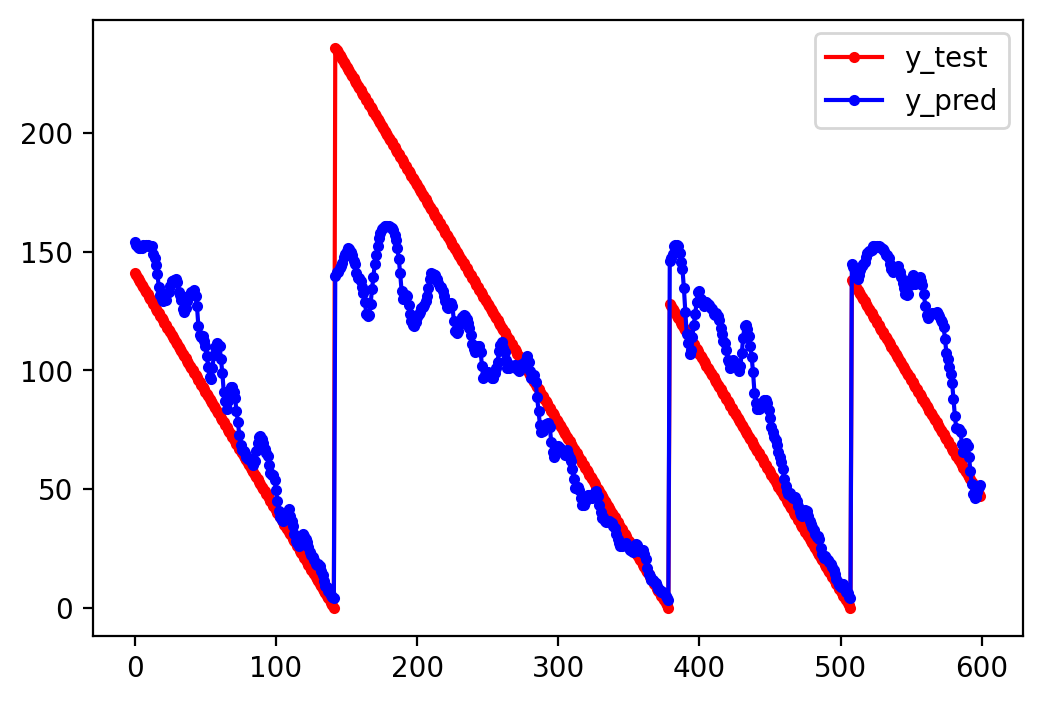

In [56]:
show_regression_result(label_array.ravel(), y_pred.ravel(),600)

## 테스트 데이터에 적용
- 테스트 데이터의 각 엔진별 마지막 50 샘플을 입력으로 사용한다
- 마지막 샘플수가 50보다 작은 경우는 테스트할 수 없다

In [57]:
sequence_cols = features
sequence_length = 50
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 24)

In [58]:
# test_df의 마지막 샘플의 크기가 50 이상인지를 확인
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [59]:
len(y_mask), np.array(y_mask).sum()

(100, 93)

- 회귀 레이블 얻기

In [60]:
y_test = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
y_test

array([ 69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,  83,  84,
        50,  28,  87,  16,  57, 113,  20, 119,  66,  97,  90, 115,   8,
        48, 106,   7,  11,  19,  21,  50,  28,  18,  10,  59, 109, 114,
        47, 135,  92,  21,  79, 114,  29,  26,  97, 137,  15, 103,  37,
       114, 100,  21,  54,  72,  28, 128,  14,  77,   8, 121,  94, 118,
        50, 131, 126, 113,  10,  34, 107,  63,  90,   8,   9, 137,  58,
        89, 116, 115, 136,  28,  38,  20,  85,  55, 128, 137,  82,  59,
       117,  20], dtype=int64)

In [61]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [62]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 24)
(93, 1)


In [63]:
y_pred = model.predict(seq_array_test_last)

3/3 [==============================] - 0s 6ms/step


MAE= 13.710741217418384
rmse= 19.14614944504944
max error= 77.04267883300781
R2= 0.7822372571416689


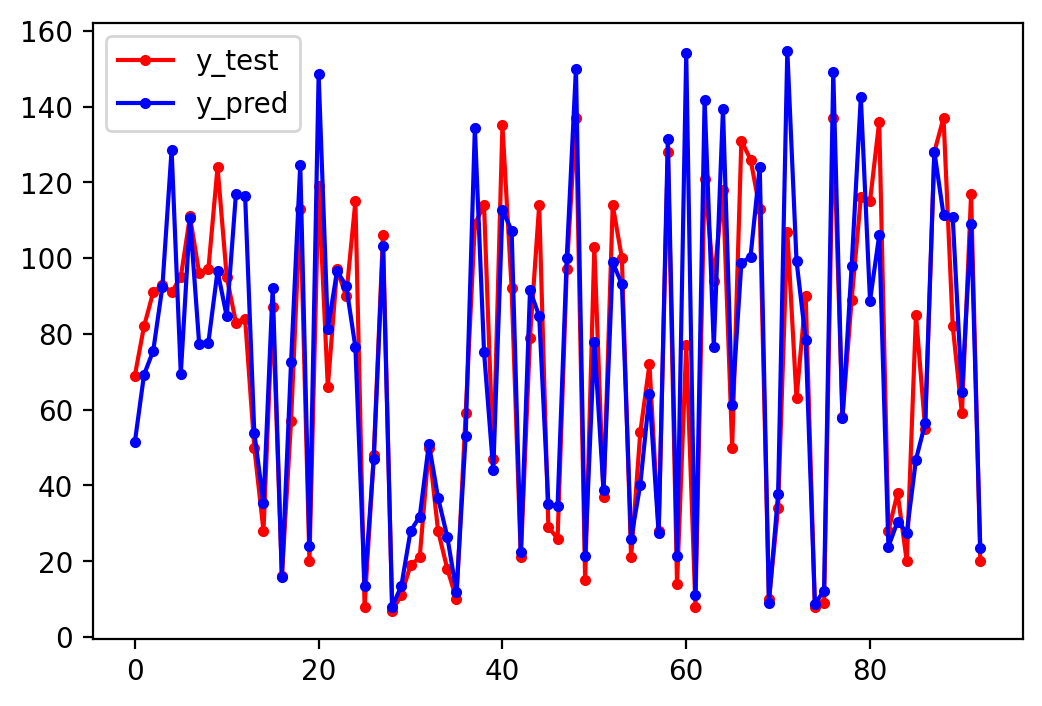

In [64]:
# 회귀 성능
show_regression_result(y_test, y_pred.ravel(),100)

## 이진 분류 모델

In [65]:
# 이진분류 레이블 얻기
res2 = []
label = ["label"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

- softmax 대신 sigmoid를 사용할 수 있다 (이진 분류시)
- loss='binary_crossentropy'로 지정해야 한다

In [66]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(n_steps, nb_features), # 스텝 수, 특성 수
         units=100))                          # 셀의 수

model.add(Dense(units=nb_out, activation='sigmoid'))

In [67]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               50000     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 50101 (195.71 KB)
Trainable params: 50101 (195.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [68]:
seq_array.shape, label_array.shape

((15631, 50, 24), (15631, 1))

In [69]:
%%time
# fit the network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.1, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

Epoch 1/100
71/71 [==============================] - 9s 87ms/step - loss: 0.3246 - accuracy: 0.8575 - val_loss: 0.1837 - val_accuracy: 0.9239
Epoch 2/100
71/71 [==============================] - 5s 73ms/step - loss: 0.1401 - accuracy: 0.9473 - val_loss: 0.1665 - val_accuracy: 0.9335
Epoch 3/100
71/71 [==============================] - 5s 70ms/step - loss: 0.1209 - accuracy: 0.9527 - val_loss: 0.1223 - val_accuracy: 0.9418
Epoch 4/100
71/71 [==============================] - 4s 64ms/step - loss: 0.0971 - accuracy: 0.9612 - val_loss: 0.0727 - val_accuracy: 0.9687
Epoch 5/100
71/71 [==============================] - 5s 71ms/step - loss: 0.0955 - accuracy: 0.9606 - val_loss: 0.1208 - val_accuracy: 0.9450
Epoch 6/100
71/71 [==============================] - 5s 68ms/step - loss: 0.0902 - accuracy: 0.9613 - val_loss: 0.0836 - val_accuracy: 0.9584
Epoch 7/100
71/71 [==============================] - 5s 74ms/step - loss: 0.0837 - accuracy: 0.9664 - val_loss: 0.1017 - val_accuracy: 0.9546
CPU ti

In [71]:
label_array_test_last = test_df.groupby('id')['label'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1)
label_array_test_last.shape

(93, 1)

In [72]:
# 이진 분류 확률을 얻는다
y_pred_test = model.predict(seq_array_test_last)
show_clf_result(label_array_test_last, y_pred_test > 0.5)

3/3 [==============================] - 1s 7ms/step
[[67  1]
 [ 6 19]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        68
           1       0.95      0.76      0.84        25

    accuracy                           0.92        93
   macro avg       0.93      0.87      0.90        93
weighted avg       0.93      0.92      0.92        93

